# Esercitazione II
1. Implementare un'architettura MLP in PyTorch e utilizzarla per un task di classificazione sul dataset MNIST.
2. Confrontare i risultati con il dataset Digits.

In [ ]:
import torch

## Implementazione del MLP

### Funzioni di attivazione

Di seguito sono riportate le funzioni di attivazione per lo strato nascosto (`ReLU`) e lo strato di output (`Softmax`). \
La scelta della ReLU è giustificata dal fatto che è la tecnica generalmente più adottata in associazione al `He` initialization. ([Referenze](#Referenze))

### Funzione di loss

La funzione di costo scelta è la `cross-entropy loss`, ampiamente utilizzata per classificare il dataset MNIST.

### Inizializzazione Kaiming-He

Questa funzione serve a inizializzare i pesi tramite il metodo `He`, la quale è più adatta per le reti che utilizzano funzioni di attivazione ReLU (Rectified Linear Unit). 

Questo metodo chiamato anche `Kaiming`, calcola i pesi come un numero casuale con una distribuzione di probabilità gaussiana con media `0,0` e deviazione standard di $\sqrt{\frac{2}{n}}$, dove `n` è il numero di input al nodo.

$$ W \rightarrow \mathcal{N}(0, \sqrt{\frac{2}{n}})$$

Per altre funzioni di attivazione, come la `sigmoide` o la `tangente iperbolica`, potrebbero essere più appropriate strategie di inizializzazione diverse.

### Funzione feedforward

Nella funzione di `feedforward`, `a` contiene tutte le attivazioni dei layer, e `z` i valori lineari prima della funzione di attivazione. \
Dopodiché viene implementato il passaggio della moltiplicazione matrice dei pesi $\odot$ attivazione precedente, e si applica la funzione di attivazione ReLU. Il layer finale usa Softmax, perché è un problema di classificazione multiclasse.

### Backpropagation

Nella funzione di backpropagation, `delta_error` memorizza quanto ogni neurone ha contribuito all’errore finale, e `delta_error[L]` calcola il gradiente dell’errore per l’output layer. In `avg_b[L]` e `avg_w[L]` accumulo i gradienti del bias e dei pesi per l’ultimo layer. L'ultimo ciclo percorre i layer nascosti all’indietro.

### Training Loop

Il `running_loss` tiene traccia della somma delle loss di tutti i batch per poi calcolare la media finale per epoca. Il `train_loader` fornisce batch di immagini e label.
Ogni immagine viene passata attraverso la rete che produce `a_values` e `z_values`. Dopodiché, si calcola la loss tra l’output `a_values[-1]` e `y_onehot[b].`\
Si accumula la loss nel batch `(batch_loss += loss.item())` e si esegue la backpropagation per aggiornare i gradienti.  \
Dopo aver elaborato tutti i batch, la rete viene valutata sul dataset di test, calcolando l’accuracy.

### Calcolo accuretezza

La funzione `validate` serve per valutare la performance della rete, invece `compute_accuracy()` è semplicemente un alias di `validate()` per eventuali usi futuri.

## Costruttore MLP

In [ ]:
import torch

class ManualMLP:
    def __init__(self, layers_config, eta=0.09, device=None):
        self.layers_config = layers_config
        self.eta = eta
        self.device = device or torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.epoch_accuracy = []
        self.epoch_loss = []  

        # Inizializza pesi e bias
        self.weights, self.bias, self.avg_w, self.avg_b = self.initialize_weights()

    # -----------------------------
    # Funzioni di attivazione
    # -----------------------------
    def ReLU(self, x):
        return torch.maximum(x, torch.tensor(0.0, device=self.device))

    def ReLU_derivative(self, x):
        return (x > 0).float()

    def Softmax(self, x):
        exp_x = torch.exp(x - torch.max(x))
        return exp_x / torch.sum(exp_x)

    def one_hot(self, labels):
        return torch.eye(self.layers_config[-1], device=self.device)[labels]

    # -----------------------------
    # Funzione di loss
    # -----------------------------
    def cross_entropy_loss(self, y_pred, y_true):
        eps = 1e-12
        y_pred = torch.clamp(y_pred, eps, 1. - eps)
        return -torch.sum(y_true * torch.log(y_pred))

    # -----------------------------
    # Inizializzazione pesi e bias
    # -----------------------------
    def initialize_weights(self):
        weights = [None]
        bias = [None]
        avg_w = [None]
        avg_b = [None]

        for i in range(1, len(self.layers_config)):
            prev_n, curr_n = self.layers_config[i-1], self.layers_config[i]
            w = torch.normal(0, torch.sqrt(torch.tensor(2.0 / prev_n)),
                             size=(curr_n, prev_n), device=self.device)
            b = torch.zeros((curr_n, 1), device=self.device)
            weights.append(w)
            bias.append(b)
            avg_w.append(torch.zeros_like(w))
            avg_b.append(torch.zeros_like(b))
        return weights, bias, avg_w, avg_b

    # -----------------------------
    # Feedforward
    # -----------------------------
    def feedforward(self, x, weights, bias):
        a = [x.reshape(-1, 1)]
        z = [None]
        for i in range(1, len(self.layers_config) - 1):
            z_i = torch.mm(weights[i], a[i-1]) + bias[i]
            z.append(z_i)
            a.append(self.ReLU(z_i))
        z_final = torch.mm(weights[-1], a[-1]) + bias[-1]
        y_hat = self.Softmax(z_final)
        a.append(y_hat)
        z.append(z_final)
        return a, z

    # -----------------------------
    # Backpropagation
    # -----------------------------
    def backprop(self, a, z, y_true, weights, avg_w, avg_b):
        delta_error = [None] * len(a)
        L = len(self.layers_config) - 1

        # Output layer
        delta_error[L] = (a[L] - y_true.reshape(-1, 1))
        avg_b[L] += delta_error[L]
        avg_w[L] += torch.mm(delta_error[L], a[L-1].T)

        # Hidden layers
        for i in range(L-1, 0, -1):
            d_relu = self.ReLU_derivative(z[i])
            delta_error[i] = (weights[i+1].T @ delta_error[i+1]) * d_relu
            avg_b[i] += delta_error[i]
            avg_w[i] += torch.mm(delta_error[i], a[i-1].T)

    # -----------------------------
    # Training Loop
    # -----------------------------
    def train(self, train_loader, test_loader, epoch_size=10, batch_size=50):
        for epoch in range(1, epoch_size + 1):
            print(f"\nEpoch {epoch}/{epoch_size}")
            running_loss = 0.0  # <-- somma delle loss per epoca

            for i, (images, labels) in enumerate(train_loader):
                images, labels = images.to(self.device), labels.to(self.device)
                y_onehot = self.one_hot(labels)

                batch_loss = 0.0
                for b in range(images.size(0)):
                    a_values, z_values = self.feedforward(images[b], self.weights, self.bias)

                    # Calcolo della loss per il sample
                    loss = self.cross_entropy_loss(a_values[-1], y_onehot[b].reshape(-1, 1))
                    batch_loss += loss.item()

                    # Backprop
                    self.backprop(a_values, z_values, y_onehot[b], self.weights, self.avg_w, self.avg_b)

                # Media della loss del batch
                running_loss += batch_loss / images.size(0)

                # Aggiorna pesi e bias
                for l in range(1, len(self.weights)):
                    self.weights[l] -= (self.eta / batch_size) * self.avg_w[l]
                    self.bias[l]    -= (self.eta / batch_size) * self.avg_b[l]
                    self.avg_w[l].zero_()
                    self.avg_b[l].zero_()

                if (i+1) % 200 == 0:
                    print(f"  Batch {i+1}/{len(train_loader)}")

            # -------------------------
            # Validazione e logging
            # -------------------------
            acc = self.validate(test_loader)
            avg_epoch_loss = running_loss / len(train_loader)
            self.epoch_accuracy.append(acc)
            self.epoch_loss.append(avg_epoch_loss)

            print(f"Validation Accuracy after epoch {epoch}: {acc:.4f}")
            print(f"Average Training Loss: {avg_epoch_loss:.6f}")

    # -----------------------------
    # Validazione e accuratezza
    # -----------------------------
    def validate(self, loader):
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in loader:
                images, labels = images.to(self.device), labels.to(self.device)
                for b in range(images.size(0)):
                    a_values, _ = self.feedforward(images[b], self.weights, self.bias)
                    y_pred = a_values[-1]
                    if torch.argmax(y_pred) == labels[b]:
                        correct += 1
                    total += 1
        return correct / total

    def compute_accuracy(self, loader):
        return self.validate(loader)

## Analisi del dataset `MNIST`

Di seguito ho riportato l'architettura di questa rete (ho modificato un'immagine pronta) dove sostanzialmente gli iperparametri scelti sono:
- `input layer`: 784 neuroni
- `hidden layer`: 512 neuroni
- `output layer`: 10 neuroni
- `batch size`: 50
- `learning rate`: 0.09
- `activation function`: ReLU
- `activation in output layer`: Softmax

![architettura_rete](https://i.ibb.co/hRvc8dGL/arch-rete-drawio.png)

In [ ]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Normalizzazione e flatten
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.view(-1))
])

train_data = datasets.MNIST(root="./data", train=True, transform=transform, download=True)
test_data  = datasets.MNIST(root="./data", train=False, transform=transform, download=True)

train_loader = DataLoader(train_data, batch_size=50, shuffle=True)
test_loader  = DataLoader(test_data, batch_size=50)

mlp = ManualMLP(layers_config=[784, 512, 10], eta=0.09)
mlp.train(train_loader, test_loader, epoch_size=10, batch_size=50)


Epoch 1/10
  Batch 200/1200
  Batch 400/1200
  Batch 600/1200
  Batch 800/1200
  Batch 1000/1200
  Batch 1200/1200
Validation Accuracy after epoch 1: 0.9433
Average Training Loss: 0.333508

Epoch 2/10
  Batch 200/1200
  Batch 400/1200
  Batch 600/1200
  Batch 800/1200
  Batch 1000/1200
  Batch 1200/1200
Validation Accuracy after epoch 2: 0.9592
Average Training Loss: 0.171229

Epoch 3/10
  Batch 200/1200
  Batch 400/1200
  Batch 600/1200
  Batch 800/1200
  Batch 1000/1200
  Batch 1200/1200
Validation Accuracy after epoch 3: 0.9668
Average Training Loss: 0.124398

Epoch 4/10
  Batch 200/1200
  Batch 400/1200
  Batch 600/1200
  Batch 800/1200
  Batch 1000/1200
  Batch 1200/1200
Validation Accuracy after epoch 4: 0.9727
Average Training Loss: 0.097587

Epoch 5/10
  Batch 200/1200
  Batch 400/1200
  Batch 600/1200
  Batch 800/1200
  Batch 1000/1200
  Batch 1200/1200
Validation Accuracy after epoch 5: 0.9749
Average Training Loss: 0.079731

Epoch 6/10
  Batch 200/1200
  Batch 400/1200
  Ba

Si osserva che già a partire dalla 4 epoca la rete raggiunge un'accuracy del `97,27%`, per poi raggiungere il `98%` nell'ultima epoca.

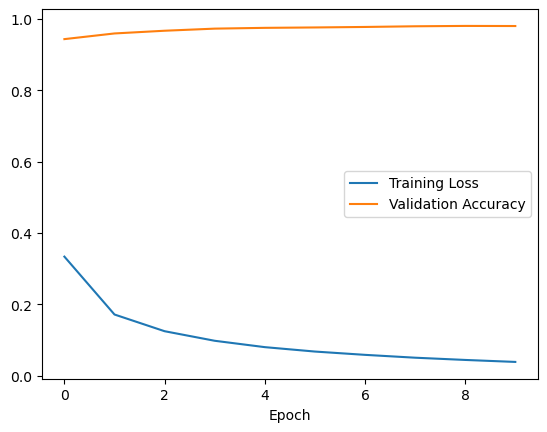

In [53]:
# Grafico Loss & Accuracy
plt.plot(mlp.epoch_loss, label="Training Loss")
plt.plot(mlp.epoch_accuracy, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.legend()
plt.show()

Questo grafico mostra come la loss sul training set diminuisce a partire dalle epoche iniziali. \
L'accuracy invece, aumenta gradualmente, pur mantenendosi valori già elevati.

## Analisi del dataset `Digits`

In [70]:
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split

digits = load_digits()
X = digits.data / 16.0  # normalizzazione [0,1]
y = digits.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = torch.tensor(X_train, dtype=torch.float32)
X_test  = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
y_test  = torch.tensor(y_test, dtype=torch.long)

train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=20, shuffle=True)
test_loader  = DataLoader(TensorDataset(X_test, y_test), batch_size=20)

mlp = ManualMLP(layers_config=[64, 128, 10], eta=0.04)
mlp.train(train_loader, test_loader, epoch_size=30, batch_size=20)


Epoch 1/30
Validation Accuracy after epoch 1: 0.8722
Average Training Loss: 1.660624

Epoch 2/30
Validation Accuracy after epoch 2: 0.8944
Average Training Loss: 0.870788

Epoch 3/30
Validation Accuracy after epoch 3: 0.9139
Average Training Loss: 0.555015

Epoch 4/30
Validation Accuracy after epoch 4: 0.9222
Average Training Loss: 0.420979

Epoch 5/30
Validation Accuracy after epoch 5: 0.9306
Average Training Loss: 0.343969

Epoch 6/30
Validation Accuracy after epoch 6: 0.9278
Average Training Loss: 0.293402

Epoch 7/30
Validation Accuracy after epoch 7: 0.9361
Average Training Loss: 0.259883

Epoch 8/30
Validation Accuracy after epoch 8: 0.9472
Average Training Loss: 0.235057

Epoch 9/30
Validation Accuracy after epoch 9: 0.9556
Average Training Loss: 0.214820

Epoch 10/30
Validation Accuracy after epoch 10: 0.9556
Average Training Loss: 0.199094

Epoch 11/30
Validation Accuracy after epoch 11: 0.9583
Average Training Loss: 0.186504

Epoch 12/30
Validation Accuracy after epoch 12: 0

Per classificare il datasets di digits `sklearn`, è stata raggiunta un'accuracy del 97.22% dopo 20 epoche, con $\eta$ = 0,04 e `batch_size` = 20.

## Referenze

- https://sausheong.github.io/posts/building-neural-networks-with-tensorflow-keras-pytorch-mxnet/

- https://medium.com/@renjiniag/understanding-multilayer-perceptrons-through-mnist-digit-classification-54463c74c35eb

- https://github.com/nipunmanral/MLP-Training-For-MNIST-Classification/blob/master/Different%20Configurations%20Report.pdf

- https://medium.com/@piyushkashyap045/mastering-weight-initialization-in-neural-networks-a-beginners-guide-6066403140e9

### Implementazione di Batch-Normalization:
- https://medium.com/thedeephub/batch-normalization-for-training-neural-networks-328112bda3ae (contiene cenni teorici + applicazione)
- https://datahacker.rs/017-pytorch-how-to-apply-batch-normalization-in-pytorch/
- https://colab.research.google.com/github/mancinimassimiliano/DeepLearningLab/blob/master/Lab3/batch_normalization.ipynb (file JupyterNotebook)
- https://how.dev/answers/batch-normalization-implementation-in-pytorch (esempio di codice + spiegazione)

### Implementazione di Drop-out:
- https://d2l.ai/chapter_multilayer-perceptrons/dropout.html (esempio)
- https://stackoverflow.com/questions/54109617/implementing-dropout-from-scratch (esempio di Inverted-dropout)